
# **GPnote - Gut phage annotation note**

The low annotation rate of gut phages remains a major challenge in gut phage research.We developed a workflow called Gut Phage genome annotation note (GPnote) for phage genome annotation. GPnote is an automated de novo genome annotation pipeline that integrates both the sequence-based and structure-based predictions of gene functions. The overall annotation rate on TGPI phages is about 57.5% (2,241/3,896 genes), much higher than current phage annotation pipelines(Pharokka, cenote-Taker3, multiPhATE2). GPnote significantly improves the annotation of phage structural proteins. 

**Note:**

Due to storage limitations and computational resources on the Kaggle platform, we chose to use a smaller PDB database instead of the AFDB50 database used in the article and HuggingFace ESMFold were used instead. The performance may have some differences. If needed, it is recommended to deploy GPnote locally on your own machine.

Developed by Xiangye Lab, Tsinghua University

Contributors: Liuzhe, Mao Sihong, Yang Yaoyu

# ****Workflow of GPnote****

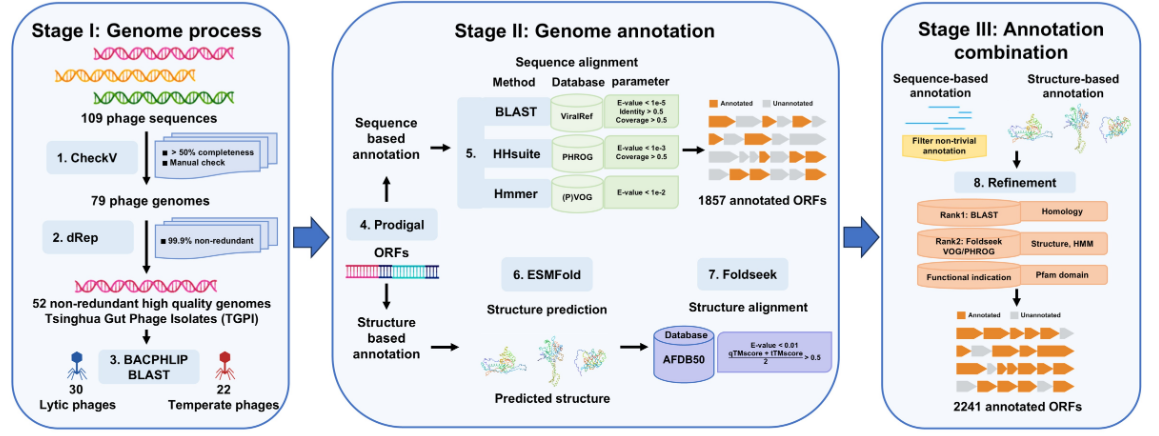

# 1. Install software and requirements

The installation process takes approximately 5 minutes.

In [1]:
%%bash
conda install -y -c bioconda -c conda-forge bcbio-gff numpy pandas scipy lastz Aragorn infernal piler-cr Prodigal diamond blast hmmer hhsuite foldseek
pip install --upgrade transformers==4.51.3 py3Dmol==2.5.1 accelerate==1.5.2
pip install biopython==1.79

Retrieving notices: ...working... done
Channels:
 - bioconda
 - conda-forge
 - rapidsai
 - nvidia
 - nodefaults
 - defaults
 - pytorch
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - aragorn
    - bcbio-gff
    - blast
    - diamond
    - foldseek
    - hhsuite
    - hmmer
    - infernal
    - lastz
    - numpy
    - pandas
    - piler-cr
    - prodigal
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aragorn-1.2.41             |       h7b50bb2_5         144 KB  bioconda
    aria2-1.37.0               |       hbc8128a_2         1.6 MB  conda-forge
    bcbio-gff-0.7.1            |     pyh7e72e81_2          21 KB  bioconda
    biopython-1.85             |  py310ha75aee5_1         2.8 MB  conda-forge
    blast-2.16.0               |       h66d330f_5       141.4 MB  bioconda
    bx

# 2. Make directory and file

Set up database process takes approximately 5 minutes.

In [2]:
%%bash
mkdir /kaggle/working/test
cp -r /kaggle/input/gpnote-db/GPnote_db /kaggle/working
cp /kaggle/input/gpnote-test/test.fasta /kaggle/working/test
cp /kaggle/input/newscript1/*.py /kaggle/working/test/
rm -rf  /kaggle/working/GPnote_db/foldseek_pdb/
mkdir  /kaggle/working/GPnote_db/foldseek_pdb/
foldseek databases PDB /kaggle/working/GPnote_db/foldseek_pdb/pdb tmp
rm -rf tmp

Create directory tmp
databases PDB /kaggle/working/GPnote_db/foldseek_pdb/pdb tmp 

MMseqs Version:              	10.941cd33
Tsv                          	false
Force restart with latest tmp	false
Remove temporary files       	false
Compressed                   	0
Threads                      	4
Verbosity                    	3


07/09 16:35:48 [NOTICE] Downloading 1 item(s)

07/09 16:35:48 [NOTICE] CUID#7 - Redirecting to https://steineggerlab.s3.amazonaws.com/foldseek/pdb100.tar.gz

07/09 16:35:49 [NOTICE] CUID#9 - Redirecting to https://steineggerlab.s3.amazonaws.com/foldseek/pdb100.tar.gz

07/09 16:35:49 [NOTICE] CUID#11 - Redirecting to https://steineggerlab.s3.amazonaws.com/foldseek/pdb100.tar.gz

07/09 16:35:49 [NOTICE] CUID#10 - Redirecting to https://steineggerlab.s3.amazonaws.com/foldseek/pdb100.tar.gz
[#970b20 67MiB/2.0GiB(3%) CN:4 DL:103MiB ETA:19s]
[#970b20 217MiB/2.0GiB(10%) CN:4 DL:132MiB ETA:13s]
[#970b20 369MiB/2.0GiB(18%) CN:4 DL:137MiB ETA:12s]
[#970b20 501MiB/2.0GiB(

In [3]:
!rm -rf test
!mkdir /kaggle/working/test
!cp /kaggle/input/gpnote-test/test.fasta /kaggle/working/test

# 3. Running GPnote annotation pipeline 

The running time depends on your input phage genome size (about 30 minutes for a 50kb genome).

**Input your own sequence in the text box below or upload into the kaggle notebook.**

***👀please input sequence in this box 👇***

***The only box you have to modify!!!***

In [4]:
input_sequence= 'ttaggcgaacacaagataccatgctgatttgtcggctggtgcgagtgcgacatatcgggttgcgcctgaaccaccgagatagtgtgcccaaatgtacccgtctgcaatgataccatcgtcttgaagaactacggtttgtccataatgatactgtgcgactacctgtgctgaggtggatggcgctgatcgcacgttgagtgtatcgacattgactttgtatgtccgtgcgataatggttacattattgttgctcggtgcgggtgctggcgtgtttgccgtgcgtgggtggaagtagccgatgattccggccttgctgagtgtgacgtatccggctttatttggattttggctcatggtgttgagcgtgccgttgctattatctcgtactacgatggcgacatggttcatgccgttgccgttccaaaatgccacgtcaccatatacgggggtgtagttgcctgcttctcgggtgaaagcgttttgcaatgcttgggagtgatcgtatcgtgcagtgtagacgcttgccgcatatccgtctaccgtgttggtgtcggctgctggaatgccgtacacgtttcgcgcgtagctgctccataggtcccagcattgaccgccgtacgcgccgtccatgtcgataatcttaccgttaaccgagttcatccattcttgaatgttcatcctagttttcctttttatgtttgggggtattgttttgtgcaaatatgctcataaagggagcgtccgccaactctggattaatggcggtgatattttcgaggattgaggtaagctcaataaagctgatgccgcctacggtgcagacaaatacgcttaccggcagtccaaggtctacatgcaagttaatcatgtccacaaaataagctactaaagtgagcatgagatacgcgaacttatgccataagccttctcgcattttttgcgagctgagcgtgttattgagtatggctttagcaagtccggtaacgtagtctacaataataaaaaagactaccgcacacacacaccacacatccgttgtggtcattgtcatagatattacctcctatttccctaacaattcaccgatgatcagcccaaaatcggcttttacctgtgaatcatcaaatctgattttaccaagtcgatagccggtggtgagtcgccgtatgatatcatctgattttttgacgtaccatgttttttcgtcaacatgattggggtctagcgtatagacggggcgagtattgtctttcgggatacgtcgtgaaacatattgtgaaacgtgcccgtcacgttccgacacggaaacccatatgccgaaacgcgcatagtcggtagtgtctagaatgtatgatagttcgccgtctgtaggggtgggggctatcagcgtgtcggattcatcccggaatttattacgaatcgcataatccgcataatcgccgtcgtactgctcaaggaaccgtccgaacttggattttgcgactttcgcactgaatccgccgtaatcagccaattcgagacatacgaaacccccgcaatagagtttgtattgttgttggttggcttgctgtgcgccaatgtccaaccggtattttgcaaaataggggttcgctttttgtattgcgttggagaggaatagtacttttgtcctgtcctgccacctgtcaacagtattgtaaaattcgctgaaactgtttacttcattgctcaaaaatctgaggttgtcggggaagatttcgtcgaaaataatcaaatgcactttagggtaggctaccgattttagcccgccagcctgtgagagcgctacgaaatagcagcacgtgcgccagtccttttcgtcccacgaagtcttatgcacctgccctttttctccattcacacgaaattcataggaggggaaaaactcctgaatgtccttgaagaacgtttccttacggtgctgctccacgtccgtgcgacgcaagtaaataaactcgtaaccgtgcttgatatattcttttatgccgtaccgttttgcggcaaaagtcttgccaagtccacgtgcgccgatcacgaaattccacggcgcgttacgagtgagcagattatgcaagtcgtagtaatcgccttctgccaatgtctgtaacgccatgtccgctcacctcctaaaacaatggggagcgtaacgtcatgaccaccgttacgctccccctattggttacggtcggctcaagggaagttatcacatgccgacaatctctattatatcacaagtctaaaatgcgggtggattcgatttaccatcccacacagtcagcagcgagtacgcctgattgtatcggcttacgtatggctggaatggatacgtgttcaaaatattggttttgagctgcgcgagattcaacgctttcggcaccttcaaggcgtttgccggtgattggtgatatgcggtcacccacaagatttgcattttatcatcaccatactcttgtggatatcccgcgtagtcttccgcgaactgtttgcgctgcccctcatgcgattcgctacgtgccgcccatgtccggaatgccgccgcttccgtcgaggtgagcggtcgggtgaaatcgcctcccgactccatgagtcccgcaatctcgggagccgcgcttttgaatgcagcgtagccggtcgggtcggcctcacgcatcttgttgagcacttgcaagcgtcgcccgaaactccattgtgcgataccgataccttggagattggccgcttccaccgcatcccattgcaggccggcttccaccgtgcctaccacgtataaagcgtaagagttttccggtgatatcgagctggatgggtgcccttgaccttgcgagtccgacggttgcccctgtgatgctttttcggaaaaattgttggccgttgtcttatagaaaatacgagtacgtgacccgctattgtccgtttcgtgcaagtataggttgtctccctgccagtgtatccacgctccaccgcgtgcggaatcagggtgtccctgattgttgtcgccggtgggattgtccacgtccgacttaggcatggtacggggatgcaagtagcctaacagtccgtcgatcgggaaccatttgagcgcacttgcgtccggattttgcgtgatgatataaatgctgttgttttttacaccctcattgccggcgactatggcaacatgcgtgtatggagtgtacgtgccgtacccccatattgccacgtcacccgccaccggcgagtatccgcttgctggaattcgctcgtacacttgctcgcaccgtgcggataccggatatgacgtgtacaagcctcccgcatagccggttggggttatgcagtcctgaatggacatgctgtacacgtccatactgtattttgcccacaggtcccagcattgcgcgccatacgcgccgtccatatcccaaaaacggtttttcgtctgatcaacccattgattaaaagtaatagccatatcaccattataggcgatatggctatccgtgtggttattgggccgctatggttttaataaccggcgttgtctgtgccgctatgattgggggttcagtggcgacaccacctttcggaaagagcgtgattcctgtcctattgggatgaattgttatgttcttatagctattgctaagagtggtggtgttttttaagtatatgaccctatagcgcaatccgagcttattggtttttgaatcggaaacgcatattgggaaacagctgtttacgtcatataggaacccattcgttgaatattttatcgaatctttgctaaatgtcatgtttctaacgtaaatatctgatagattgtctatttcgatagtgacttcaccgtatggctctagtgatttggatgtaaaaacagaaatgctctgagccatttcttcgtacaatactccaatggggatataaccgtttgaactgtccgttacgccgtaaaataaacttgaatgatacgagctttttccatagtttggcattacaggcataagacagttatcaccgtatgtgtctacgttggagaatttcacgttctcaaaattaaatgtatactgatcgtttttcacccctacgagcggtgttgccgcatgactgtcttcaaggaatctcgcatataatccgtcacagcgcagtcgggcgttgtacgataccttgaatgtcacggtatccgtatcaagttctgcatacgtgtagtgatatacgttggtaaaataagcgtcaatgtatttggattgcacaccgatggctatagtatcaatgtagatgttgttaccaaaatataccccatttgcaagatcatagcagacggcgttctggaatgatggattgttgaatgagtgaaccgtgtcgaacatcattccgccaccgttgcatttaaaatgcgtatggcaatatgtcgtgtagacgttgacgaactgacaatccgtgccgttgagataaaacccgtactgggaatccgcgctttccttgagcatgttaaccctgatattggtgaaaagcatgtccagtgcttgagttcttttcgcatagaatgacgctaccttggcacctttgaccgtcatgttcgaaacgcttacgccgtatacgtcctgttcaaaactccagcaattatcacacaggcccgcacagtcgtatacaccgccggtgattgtcgccccatatgtcttttcgccgttttcggagtatgcgccaaaatcgaacatgtccgtcatatttgccgttgcgacgaactttgcgttaggttcggcgtagaaggtgaacggattcgtcgtgttctttggaatgtcgatagttttgtccaaatggtaggttccggcggggaagtacacgccgttaaacggattgtccttgatatacgcattgatgaggtcggacaccgaatatgatgcgtcgttagggatgccgtgtagcacgacattgcagtttgaggtgatttcgtgggcgaactttgctgccttttccgcggtttcgactccgagcgccgtcaatgcttgagtgttgccgtcggccttgcttgcggcggcggtagcgtccgtccccgccttgtcccacttggttttcgctgcggttgcagcatccaccgtattatcccccagcagtgccttcgtgacttcctcatcatgggcttcacgcgactccaccgattcgatacggttcaaatgtttttcgagcgtgtcgtcaatggtatgcatactgccgttgtatccgtcgcgcaagtcggcgggatcattgtcgccatacagatttagcgcgtaattgtcggttttatcgtaaatggtgctcat'

In [5]:
with open("test.fasta","w") as fi:
    fi.write(">test\n")
    fi.write(input_sequence)
!mv test.fasta /kaggle/working/test
with open("modifiers_c11.txt","w") as fl:
    fl.write("")
!mv "modifiers_c11.txt" /kaggle/working/test

**Running the code!**

In [6]:
%%bash
cp /kaggle/input/newscript1/*.py /kaggle/working/test/
rm -rf /kaggle/working/esmfold
cd /kaggle/working/test
python gpnote.py --workdir /kaggle/working/test --fastafile test.fasta --vigapath /kaggle/working/GPnote_db --pfampath /kaggle/working/GPnote_db/HMMER_Pfam/Pfam-A.hmm --phrogspath  /kaggle/working/GPnote_db/HHsuite_PHROGs/phrogs --esmfoldpath /kaggle/working/esmfold --foldseek /kaggle/working/GPnote_db/foldseek_pdb/pdb

This is VIGA 0.11.2
Written by Enrique Gonzalez Tortuero & Vimalkumar Velayudhan
Homepage is https://github.com/EGTortuero/viga
Local time:  Wed, 09 Jul 2025 16:36:57
Data type is CON and GenBank translation table no is 11


Predicting the shape for all contigs using LASTZ
LOC_1 seems to be a linear contig according to LASTZ
Done: shape prediction took 0.009998559951782227 seconds

Running ARAGORN to predict tRNA-like sequences for all contigs
Detected 0 tRNAs in LOC_1
Done: tRNA and tmRNA detection took 0.012668132781982422 seconds

Identifying all other ncRNA (except rRNAs and tRNAs) for all contigs
Done: ncRNA detection took 1.767815113067627 seconds

Running PILER-CR to predict CRISPR repeats for all contigs
Detected 0 CRISPR repeats in LOC_1
Done: CRISPR repeats detection took 0.010833024978637695 seconds

Running Prodigal to predict the ORFs in all contigs
Detected 5 ORFs in LOC_1.fna
Done: protein prediction took 0.0979456901550293 seconds

Running DIAMOND to predict the protein

data file: test_annotated.genes.ffdata
index file: test_annotated.genes.ffindex
fasta file: test_annotated.genes.faa


- 16:39:11.840 INFO: Thread 0	LOC_1_1

- 16:39:11.855 INFO: Thread 1	LOC_1_2

- 16:39:11.859 INFO: LOC_1_1 is in A2M, A3M or FASTA format

- 16:39:11.864 INFO: Searching 38880 database HHMs without prefiltering

- 16:39:11.883 INFO: Iteration 1

- 16:39:11.891 INFO: LOC_1_2 is in A2M, A3M or FASTA format

- 16:39:11.896 INFO: Searching 38880 database HHMs without prefiltering

- 16:39:11.913 INFO: Iteration 1

- 16:39:12.109 INFO: Scoring 38880 HMMs using HMM-HMM Viterbi alignment

- 16:39:12.161 INFO: Alternative alignment: 0

- 16:39:12.221 INFO: Scoring 38880 HMMs using HMM-HMM Viterbi alignment

- 16:39:12.255 INFO: Alternative alignment: 0

- 16:39:26.549 INFO: 38880 alignments done

- 16:39:26.676 INFO: Alternative alignment: 1

- 16:39:26.798 INFO: 133 alignments done

- 16:39:26.798 INFO: Alternative alignment: 2

- 16:39:26.798 INFO: Alternative alignment: 3

- 16:39:27.149 INFO: Premerge done

- 16:39:27.152 INFO: Realigning 11 HMM-HMM alignments using Maximum Accuracy algori

Create directory tmp
easy-search /kaggle/working/esmfold /kaggle/working/GPnote_db/foldseek_pdb/pdb test.foldseek.tsv tmp --format-output query,target,theader,pident,alntmscore,qtmscore,ttmscore,evalue,prob,rmsd 

MMseqs Version:                    	10.941cd33
Seq. id. threshold                 	0
Coverage threshold                 	0
Coverage mode                      	0
Max reject                         	2147483647
Max accept                         	2147483647
Add backtrace                      	false
TMscore threshold                  	0
TMscore threshold mode             	0
TMalign hit order                  	0
TMalign fast                       	1
Preload mode                       	0
Threads                            	4
Verbosity                          	3
LDDT threshold                     	0
Sort by structure bit score        	1
Alignment type                     	2
Exact TMscore                      	0
Substitution matrix                	aa:3di.out,nucl:3di.out
Alignment m

# 4. Visualize predicted protein structure

In [7]:
ORF_ID="1" #Please input ORF_ID you want to see structure.

In [8]:
!pip install -q py3Dmol
import py3Dmol
ID=2#查看第几个蛋白结构
pdb_path = f'/kaggle/working/esmfold/LOC_1_{ORF_ID}.pdb'  # 指定你的PDB文件路径

# 读取PDB文件内容
with open(pdb_path, 'r') as f:
    pdb_data = f.read()

# 可视化
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=800, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.